# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


### Import necessary modules

In [33]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [165]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

### Define directories and dataset names

In [108]:
### Define directodies and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR + "\\" + 'Sample_Input'
out_path = ROOT_DIR + "\\" + 'Sample_Output'

## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "Copperbelt.gpkg"
adm_col_name = "ADM1_NAME"          ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"

## mines layer
mines_path = in_path + "\\"+ 'mines'
mines_name = 'mines_zambia.gpkg'

## RWI layer
rwi_path = in_path + "\\"+ 'rwi'
rwi_name = 'zmb_relative_wealth_index.csv'

## MTF survey
mtf_path = in_path + "\\"+ 'MTF_survey'
mtf_name = 'MTFData_ListC23.csv'

In [36]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [37]:
## admininstrative boundary
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)

## mines
mines = gpd.read_file(mines_path + "\\" + mines_name)

## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "\\" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

## Part 1. Create base grid with H3

### H3 - Hegagon - grid

In [38]:
# Make a copy of the original dataframe (as it might require some changes)
admin_gdf_copy_2 = admin_gdf.buffer(1.245)     ## this is ~15km --> 0.83*1.5

In [39]:
## No of multipolygons in the geometry
#check_geom_type = admin_gdf_copy.geometry.apply(lambda x: list(x))[0]

#len(check_geom_type)

It seems that the geometry is not a polygon but multipolygon. That is, the h3.polyfill will not work. In case the original layer consists of many parts then you shall follow a "merging" approach using a small buffer as described [here](https://gis.stackexchange.com/questions/311931/geopandas-equivalent-of-st-makepolygon/312004#312004). 

However, if polygons are not close this will not work. Thus, the following process (which I do only for one of them) needs to be done for each polygon separately -- unless you write some code to do this automatically! :)

In [40]:
#polygon = check_geom_type[0]
#polygon

In [41]:
#combined = [unary_union(polygon)]
#admin_gdf_copy.geometry = combined

In [42]:
# Convert this to geojson
gj = gpd.GeoSeries([admin_gdf_copy_2.geometry[0]]).__geo_interface__
geoJson = gj['features'][0]['geometry']

In [43]:
size = 7 ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = pd.DataFrame(h3.polyfill(geoJson, size), columns=['hexagons'])
hexagons.head()

,hexagons
0,875532929ffffff
1,87346d88bffffff
2,873996324ffffff
3,873992082ffffff
4,87346b05dffffff


In [44]:
hexagons['geometry'] = hexagons.hexagons.apply(lambda hex: Polygon(h3.h3_to_geo_boundary(hex)))
hexagons['centeroid'] = hexagons.hexagons.apply(lambda hex: h3.h3_to_geo(hex))

crs = {'init': 'epsg:4326'}

hexagons = gpd.GeoDataFrame(hexagons, crs=crs, geometry=hexagons.geometry)
hexagons['lon'] = hexagons['centeroid'].apply(lambda x: x[0])
hexagons['lat'] = hexagons['centeroid'].apply(lambda x: x[1])

hexagons = hexagons.drop(['centeroid'], axis=1)

display(hexagons.head())

,hexagons,geometry,lon,lat
0,875532929ffffff,"POLYGON ((26.93089 -13.85335, 26.92073 -13.863...",26.918169,-13.848810
1,87346d88bffffff,"POLYGON ((30.03398 -13.28807, 30.02385 -13.298...",30.021068,-13.283464
2,873996324ffffff,"POLYGON ((29.19144 -12.14067, 29.18143 -12.151...",29.178573,-12.136307
3,873992082ffffff,"POLYGON ((28.07111 -11.56009, 28.06118 -11.570...",28.058328,-11.555888
4,87346b05dffffff,"POLYGON ((28.13316 -14.79145, 28.12288 -14.801...",28.120352,-14.786684


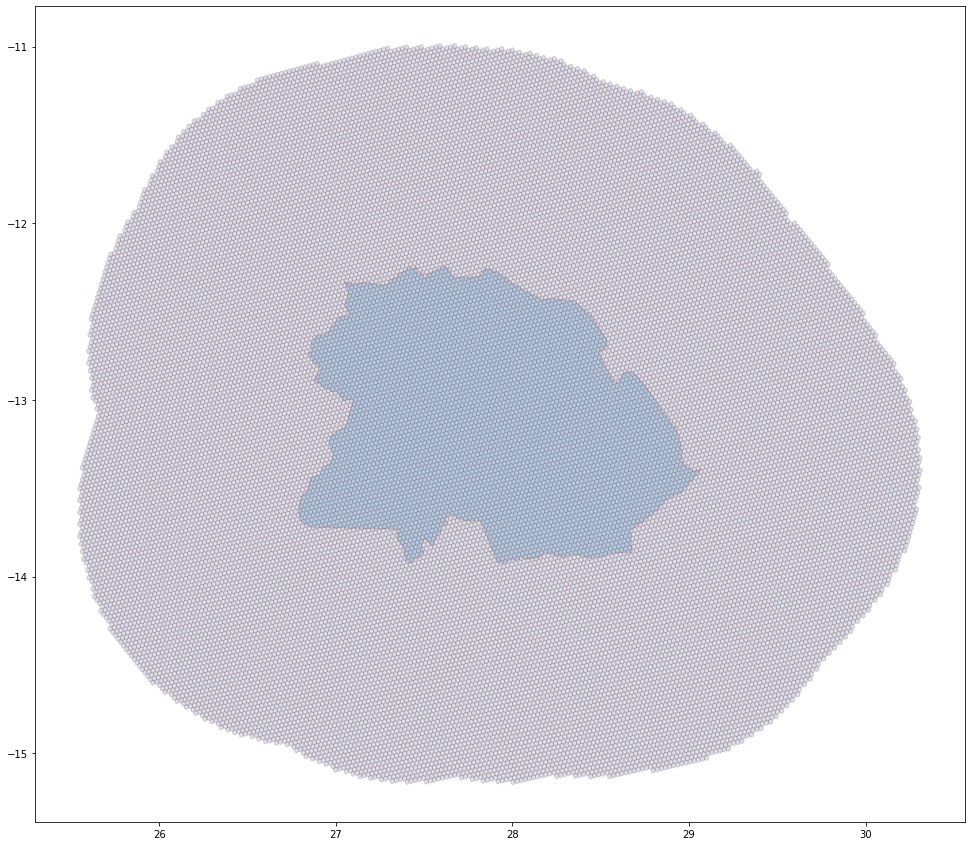

In [45]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [46]:
#Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, admin_gdf[[adm_col_name, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[adm_col_name].notnull()]

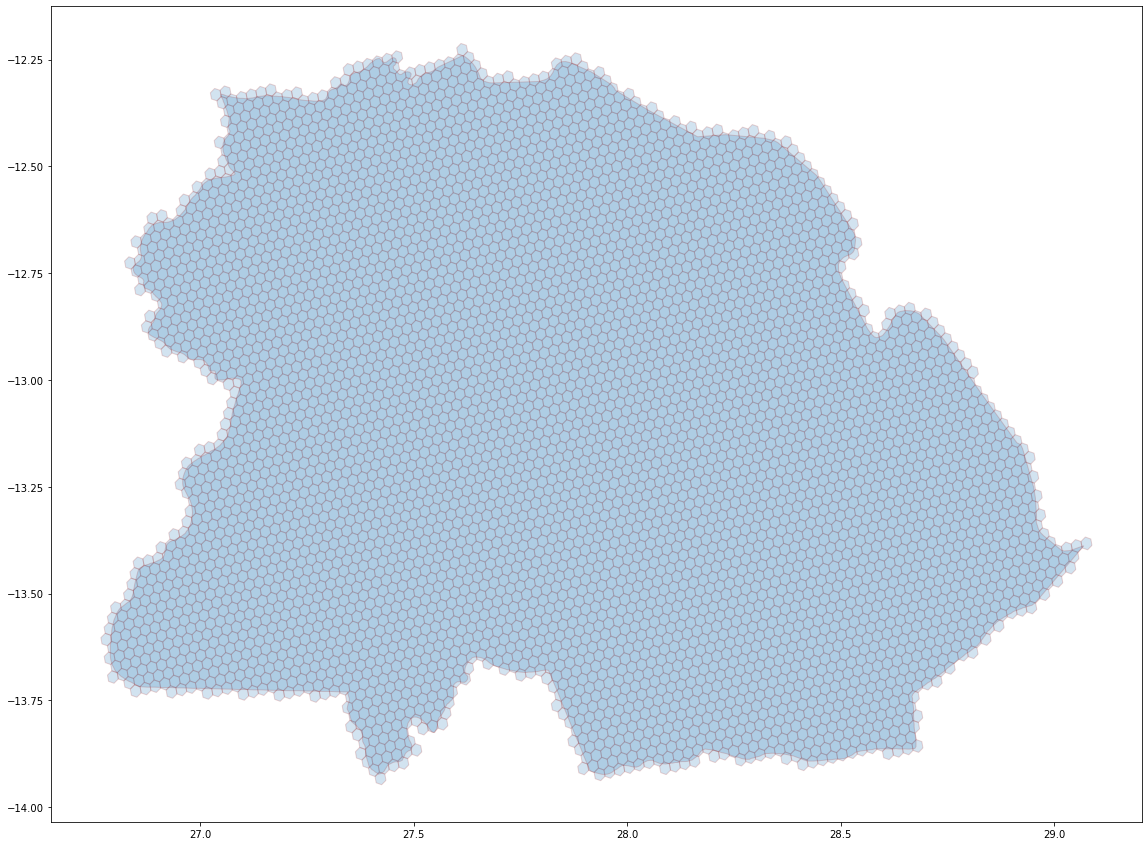

In [47]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [48]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False)

## Step 2. Extract GIS-based attributes

#### Select base map grid and proceed with processing

In [49]:
#hexagons = gpd.read_file(outpath + "\\" + "hex6_with_neighbors.geojson")

In [50]:
grid = hexagons

In [51]:
grid['id'] = range(1, len(grid)+1)

In [52]:
grid.head(3)

,hexagons,geometry,lon,lat,index_right,ADM1_NAME,id
16,875534681ffffff,"POLYGON ((27.46156 -13.14736, 27.45147 -13.157...",27.448809,-13.142907,0.0,COPPERBELT,1
20,875536203ffffff,"POLYGON ((27.13663 -13.73417, 27.12648 -13.744...",27.123894,-13.729640,0.0,COPPERBELT,2
36,8734692eeffffff,"POLYGON ((28.13683 -13.43994, 28.12670 -13.450...",28.124030,-13.435409,0.0,COPPERBELT,3


### Define extraction functions

In [53]:
def processing_raster(name, method, clusters):
    messagebox.showinfo('DemandMapping', 'Select the ' + name + ' map')
    raster=rasterio.open(filedialog.askopenfilename(filetypes = (("rasters","*.tif"),("all files","*.*"))))
    
    clusters = zonal_stats(
        clusters,
        raster.name,
        stats=[method],
        prefix=name, geojson_out=True, all_touched=True)
    
    print(datetime.datetime.now())
    return clusters

In [54]:
def finalizing_rasters(workspace, clusters, crs):
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(clusters)}
        dst.write(json.dumps(collection))
  
    clusters = gpd.read_file(output)
    os.remove(output)
    
    print(datetime.datetime.now())
    return clusters

In [76]:
def spatialjoinvectors(name, column, admin, crs, clusters, val):
    messagebox.showinfo('DemandMapping', 'Select the ' + name + ' map')
    # points=gpd.read_file(filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
    points=gpd.read_file(filedialog.askopenfilename(filetypes = (("all files","*.*"),)))
    points.head(5)
    
    points_clip = gpd.clip(points, admin)
    points_clip.crs = {'init' :'epsg:4326'}
    points_proj=points_clip.to_crs({ 'init': crs})
    if 'Mines' in name:
        points_proj[column] = points_proj[column].str.replace(',', '')
        points_proj[column] = points_proj[column].astype(float)     ## added so that the sample mining productions works; you may need to update this as per layer used
    
    gdf_points = points_proj[[column, "geometry"]]
    pointsInPolygon = gpd.sjoin(gdf_points, clusters, how="inner", op='within')
    ## Defining operation on the selected data
    if val=="sum":
        group_by_name = pointsInPolygon[["id", column]].groupby(["id"]).sum().reset_index()
    elif val=="mean":
        group_by_name = pointsInPolygon[["id", column]].groupby(["id"]).mean().reset_index()
    clusters = pd.merge(clusters, group_by_name[['id', column]], on='id', how = 'left')
    
    return clusters

## Extract raster values to hexagons

Extract count of buildings per hex

In [57]:
grid = processing_raster("buildings", "count", grid)      #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-05-25 13:45:07.396633


#### ..You can extract values from other raster layers here too..

##### Once done with rasters run this cell

In [58]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2023-05-25 13:45:11.320961


In [59]:
grid.drop(['index_right'], axis=1, inplace=True)
grid.head(4)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry
0,COPPERBELT,875534681ffffff,1,-13.142907,27.448809,19,"POLYGON ((27.46156 -13.14736, 27.45147 -13.157..."
1,COPPERBELT,875536203ffffff,2,-13.729640,27.123894,0,"POLYGON ((27.13663 -13.73417, 27.12648 -13.744..."
2,COPPERBELT,8734692eeffffff,3,-13.435409,28.124030,24,"POLYGON ((28.13683 -13.43994, 28.12670 -13.450..."
3,COPPERBELT,8755340c8ffffff,4,-12.740176,27.673773,9,"POLYGON ((27.68654 -12.74457, 27.67649 -12.754..."


## Extract information from vector layers

Extract sum production of mines in each cluster (hex)

In [93]:
## Run the extraction
#grid.drop(['Commodity Production - tonne (tonnes)'], axis=1, inplace=True) ##uncomment if you want to rerun
columnNameMines = "Commodity Production - tonne (tonnes)"
#columnName = 'Ore processed (tonnes)'
grid = spatialjoinvectors("Mines", columnNameMines, admin_gdf, crs_WGS84, grid, "sum")
grid[columnNameMines] = grid[columnNameMines].fillna(0)

In [85]:
grid[columnName].sum()

286573.0

In [157]:
## Run the extraction
#grid.drop(['rwi'], axis=1, inplace=True) ##uncomment if you want to rerun
columnNameRWI = "rwi"
grid = spatialjoinvectors("RWI", columnNameRWI, admin_gdf, crs_WGS84, grid, 'mean')
averageRwi = grid[columnNameRWI].mean()
grid[columnNameRWI] = grid[columnNameRWI].fillna(averageRwi)

In [158]:
grid[columnName].mean()

-0.2352888011152416

# Step 3. Constructing Multi-vector Demand

### Industry

In [167]:
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes),IndustryEnergy,Location,Status_electrified,ResidentialEnergyCorrPerHH,ResHHNo,ResidentialEnergy,rwi
0,COPPERBELT,875534681ffffff,1,-13.1429,27.4488,19,"POLYGON ((27.46156 -13.14736, 27.45147 -13.157...",0.0000,0.0000,rural,elec,"3,093.0323",0.0000,0.0000,-0.2353
1,COPPERBELT,875536203ffffff,2,-13.7296,27.1239,0,"POLYGON ((27.13663 -13.73417, 27.12648 -13.744...",0.0000,0.0000,rural,elec,"3,093.0323",0.0000,0.0000,-0.2353
2,COPPERBELT,8734692eeffffff,3,-13.4354,28.1240,24,"POLYGON ((28.13683 -13.43994, 28.12670 -13.450...",0.0000,0.0000,rural,elec,"9,517.4753",0.0000,0.0000,-0.7240


In [168]:
#Assess total energy consumption and total production
elec_nonFerrousMetals = 22897 #PJ
elec_nonFerrousMetals = elec_nonFerrousMetals / (3.6e-6) #conversion en MWh
total_production = sum(grid[columnNameMines])
print(f"{total_production:,.0f}")
print(f"{elec_nonFerrousMetals:,.0f}")
print("energy per tonne of ore:", f"{elec_nonFerrousMetals/total_production:,.0f}", "MWh/t")

286,573
6,360,277,778
energy per tonne of ore: 22,194 MWh/t


In [169]:
#Allocate to each hexagon the industry energy consumption
grid["IndustryEnergy"]=grid[columnNameMines]/total_production * elec_nonFerrousMetals
grid.head(3)
total_industryenergy = grid["IndustryEnergy"].sum()
print(f"{total_industryenergy:,.0f}") #kWh

6,360,277,778


In [170]:
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes),IndustryEnergy,Location,Status_electrified,ResidentialEnergyCorrPerHH,ResHHNo,ResidentialEnergy,rwi
0,COPPERBELT,875534681ffffff,1,-13.1429,27.4488,19,"POLYGON ((27.46156 -13.14736, 27.45147 -13.157...",0.0000,0.0000,rural,elec,"3,093.0323",0.0000,0.0000,-0.2353
1,COPPERBELT,875536203ffffff,2,-13.7296,27.1239,0,"POLYGON ((27.13663 -13.73417, 27.12648 -13.744...",0.0000,0.0000,rural,elec,"3,093.0323",0.0000,0.0000,-0.2353
2,COPPERBELT,8734692eeffffff,3,-13.4354,28.1240,24,"POLYGON ((28.13683 -13.43994, 28.12670 -13.450...",0.0000,0.0000,rural,elec,"9,517.4753",0.0000,0.0000,-0.7240


### Residential

In [171]:
elec_residential = 14481  #PJ
elec_residential = elec_residential / (3.6e-6) #conversion en MWh
print(f"{elec_residential:,.0f}") #MWh

4,022,500,000


In [173]:
grid["nightlight"] = np.random.randint(-10, 10, grid.shape[0]) ## this is a place holder, we can use actual nightlight data here

In [174]:
# for each hexagon, determine if it's rural or urban --> to change!
grid["Location"] = grid.apply(lambda row: ("rural" if ((row['buildingscount'] < 100))
                                             else "urban"), axis=1)
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row['nightlight'] > 0))
                                             else "nonelec"), axis=1)

In [175]:
# for each hexagon, assessment of the number of HH
shareResBuildings = {"urban": 0.60, "rural": 0.99}
elec = {"elec": 0, "nonelec": 1} #https://population.un.org/Household/index.html#/countries/ https://dhsprogram.com/publications/publication-fr361-dhs-final-reports.cfm
#print(grid["Location"].map(shareResBuildings))
grid["ResHHNo"]=grid["buildingscount"]*grid["Location"].map(shareResBuildings)*grid["Status_electrified"].map(elec)
grid.head(4)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes),IndustryEnergy,Location,Status_electrified,ResidentialEnergyCorrPerHH,ResHHNo,ResidentialEnergy,rwi,nightlight
0,COPPERBELT,875534681ffffff,1,-13.1429,27.4488,19,"POLYGON ((27.46156 -13.14736, 27.45147 -13.157...",0.0000,0.0000,rural,elec,"3,093.0323",0.0000,0.0000,-0.2353,5
1,COPPERBELT,875536203ffffff,2,-13.7296,27.1239,0,"POLYGON ((27.13663 -13.73417, 27.12648 -13.744...",0.0000,0.0000,rural,nonelec,"3,093.0323",0.0000,0.0000,-0.2353,-5
2,COPPERBELT,8734692eeffffff,3,-13.4354,28.1240,24,"POLYGON ((28.13683 -13.43994, 28.12670 -13.450...",0.0000,0.0000,rural,nonelec,"9,517.4753",23.7600,0.0000,-0.7240,-4
3,COPPERBELT,8755340c8ffffff,4,-12.7402,27.6738,9,"POLYGON ((27.68654 -12.74457, 27.67649 -12.754...",0.0000,0.0000,rural,nonelec,"3,093.0323",8.9100,0.0000,-0.2353,-7


In [127]:
#Energy consumption from the MTF survey (kWh/HH)
# Load data into Pandas DataFrame

df_mtfdata = pd.read_csv(mtf_path + "//" + mtf_name)
colMTF = "C23"
df_mtfdata = df_mtfdata[df_mtfdata[colMTF]<14080]# ignore line with very high value (doesn't match the other HH)
df_mtfdata

,HouseholdID,PROVINCE,DISTRICT,TOWNSHIP_COMPOUND_VILLAGE,LOCALITY,EANUM,LOF,ENUMID,SUPID,DOV,...,C180_1,C180_2,C180_3,C180_4,C180_5,U4_1,U4_2,U4_3,U4_4,U4_5
0,1037205,Central,1,chibombo(mwashiala),Rural,372,Nyanja,511,507,1,...,NaN,NaN,NaN,nan,NaN,Not a member,NaN,NaN,nan,nan
1,1112803,Central,2,Railways,Urban,1128,Bemba,507,507,1,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
2,1112809,Central,2,Railways,Urban,1128,English,507,507,1,...,NaN,NaN,NaN,nan,NaN,Not a member,NaN,NaN,nan,nan
3,1112812,Central,2,railways,Urban,1128,Bemba,511,507,1,...,NaN,NaN,NaN,nan,NaN,Not a member,NaN,NaN,nan,nan
4,1128611,Central,2,Natuseko,Urban,1286,Bemba,507,507,1,...,NaN,NaN,NaN,nan,NaN,Income generating activities,NaN,NaN,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,9254803,Southern,9,NEW TOWN SHIP,Urban,2548,Tonga,513,501,1,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
225,9254806,Southern,9,bbunta,Urban,2548,Tonga,513,501,1,...,NaN,NaN,NaN,nan,NaN,Religious related activities,NaN,NaN,nan,nan
226,9254809,Southern,9,bbunta,Urban,2548,Tonga,501,513,1,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
227,9254814,Southern,9,bbunta,Urban,2548,Tonga,505,501,1,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,nan


In [176]:
provinces = df_mtfdata["PROVINCE"].unique()
provinces

array(['Central', 'Copperbelt', 'Eastern', 'Luapula', 'Lusaka',
       'North western', 'Southern', 'WESTERN'], dtype=object)

In [177]:
# Results for all HH: consumption in kWh per month
energycons_res_mtf={}
for province in provinces:
    nb = (df_mtfdata['PROVINCE'] == province).sum()
    min_ = df_mtfdata[(df_mtfdata['PROVINCE'] == province)][colMTF].min()
    max_ = df_mtfdata[(df_mtfdata['PROVINCE'] == province)][colMTF].max()
    mean_ = df_mtfdata[(df_mtfdata['PROVINCE'] == province)][colMTF].mean()
    median_ = df_mtfdata[(df_mtfdata['PROVINCE'] == province)][colMTF].median()
    energycons_res_mtf[province] = {"nb": nb, "min": min_, "max": max_, "mean": mean_, "median": median_}
nb = len(df_mtfdata.index)
min_ = df_mtfdata[colMTF].min()
max_ = df_mtfdata[colMTF].max()
mean_ = df_mtfdata[colMTF].mean()
median_ = df_mtfdata[colMTF].median()
energycons_res_mtf["Total"] = {"nb": nb, "min": min_, "max": max_, "mean": mean_, "median": median_}
energycons_res_mtf = pd.DataFrame(energycons_res_mtf).transpose()
pd.options.display.float_format = '{:,.0f}'.format
energycons_res_mtf

,nb,min,max,mean,median
Central,6,46,200,130,150
Copperbelt,93,15,"1,117",258,220
Eastern,10,100,150,105,100
Luapula,12,105,376,219,218
Lusaka,73,44,"1,000",248,200
North western,3,44,256,181,243
Southern,30,40,600,145,100
WESTERN,1,24,24,24,24
Total,228,15,"1,117",226,194


In [178]:
# Results for rural and urban HH
energycons_res_mtf_loc={}
locs = df_mtfdata["LOCALITY"].unique()
for loc in locs:
    energycons_res_mtf_tmp={}
    for province in provinces:
        criteria = (df_mtfdata['PROVINCE'] == province) & (df_mtfdata["LOCALITY"] == loc)
        nb = criteria.sum()
        min_ = df_mtfdata[criteria][colMTF].min()
        max_ = df_mtfdata[criteria][colMTF].max()
        mean_ = df_mtfdata[criteria][colMTF].mean()
        median_ = df_mtfdata[criteria][colMTF].median()
        energycons_res_mtf_tmp[province] = {"nb": nb, "min": min_, "max": max_, "mean": mean_, "median": median_}
    energycons_res_mtf_loc[loc] = pd.DataFrame(energycons_res_mtf_tmp).transpose()
pd.options.display.float_format = '{:,.0f}'.format
energycons_res_mtf_loc["Urban"]

,nb,min,max,mean,median
Central,4,46,200,112,100
Copperbelt,91,15,"1,117",258,220
Eastern,9,100,150,106,100
Luapula,6,105,235,182,206
Lusaka,68,44,750,246,200
North western,3,44,256,181,243
Southern,23,50,350,124,100
WESTERN,1,24,24,24,24


In [179]:
energycons_res_mtf_loc["Rural"]

,nb,min,max,mean,median
Central,2,150,183,166,166
Copperbelt,2,200,250,225,225
Eastern,1,100,100,100,100
Luapula,6,208,376,256,242
Lusaka,5,100,"1,000",280,100
North western,0,nan,nan,nan,nan
Southern,7,40,600,215,60
WESTERN,0,nan,nan,nan,nan


In [180]:
adm = grid["ADM1_NAME"].unique()
print (adm)
energyConsHH = energycons_res_mtf["mean"] * 12 # dictionnary for each region one value # multiply by 12 because it was a monthly consumption
energyConsHH.index = energyConsHH.index.str.upper()
energyConsHH

['COPPERBELT']


CENTRAL         1,558
COPPERBELT      3,093
EASTERN         1,260
LUAPULA         2,630
LUSAKA          2,982
NORTH WESTERN   2,172
SOUTHERN        1,742
WESTERN           288
TOTAL           2,710
Name: mean, dtype: float64

In [181]:
##for each hexagon, allocated the wri indicator
##incomeIndex = 'rwi'
#grid = spatialjoinvectors("Wealth", columnNameRWI, admin_gdf, crs_WGS84, grid, "mean")
#averageRwi = 1 #compute the average of rwi
#grid.head(4)

In [182]:
# Energy Consumption assessment
averageRwi = grid['rwi'].mean()
grid["ResidentialEnergyCorrPerHH"] = grid['rwi']/averageRwi*grid["ADM1_NAME"].map(energyConsHH)
grid["ResidentialEnergy"] = grid["ResHHNo"] * grid["ResidentialEnergyCorrPerHH"] * (grid["Status_electrified"]!="nonelec")
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes),IndustryEnergy,Location,Status_electrified,ResidentialEnergyCorrPerHH,ResHHNo,ResidentialEnergy,rwi,nightlight
0,COPPERBELT,875534681ffffff,1,-13,27,19,"POLYGON ((27.46156 -13.14736, 27.45147 -13.157...",0,0,rural,elec,"3,093",0,0,-0,5
1,COPPERBELT,875536203ffffff,2,-14,27,0,"POLYGON ((27.13663 -13.73417, 27.12648 -13.744...",0,0,rural,nonelec,"3,093",0,0,-0,-5
2,COPPERBELT,8734692eeffffff,3,-13,28,24,"POLYGON ((28.13683 -13.43994, 28.12670 -13.450...",0,0,rural,nonelec,"9,517",24,0,-1,-4


### Calculate Total Demand

**Demand = Residential + Commercial + Industrial (only an EXAMPLE)**

where, 

**Residential** = No of buildings X 50 kWh/building/year  

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production - tonne (tonnes) from mines

In [183]:
grid["Residential"] = grid.apply(lambda row: (row['buildingscount']*200), axis=1)
total_residentialenergy_assessed = grid["Residential"].sum()
print(f"{total_residentialenergy_assessed:,.0f}") #kWh

45,991,200


In [184]:
grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             else row['buildingscount']*100), axis=1)
total_servicesenergy_assessed = grid["Commercial"].sum()
print(f"{total_servicesenergy_assessed:,.0f}") #kWh

16,752,300


In [185]:
grid["TotalDem"] = grid.apply(lambda row: (row['Residential'] + 
                                          row['Commercial']  
                                          # +row["IndustryEnergy"]
                                          ), axis=1)

In [186]:
total = grid.TotalDem.sum()
print(f"{total:,.0f}") #kWh

62,743,500


In [187]:
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes),IndustryEnergy,Location,Status_electrified,ResidentialEnergyCorrPerHH,ResHHNo,ResidentialEnergy,rwi,nightlight,Residential,Commercial,TotalDem
0,COPPERBELT,875534681ffffff,1,-13,27,19,"POLYGON ((27.46156 -13.14736, 27.45147 -13.157...",0,0,rural,elec,"3,093",0,0,-0,5,3800,1900,5700
1,COPPERBELT,875536203ffffff,2,-14,27,0,"POLYGON ((27.13663 -13.73417, 27.12648 -13.744...",0,0,rural,nonelec,"3,093",0,0,-0,-5,0,0,0
2,COPPERBELT,8734692eeffffff,3,-13,28,24,"POLYGON ((28.13683 -13.43994, 28.12670 -13.450...",0,0,rural,nonelec,"9,517",24,0,-1,-4,4800,2400,7200


### Export result

In [ ]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [ ]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

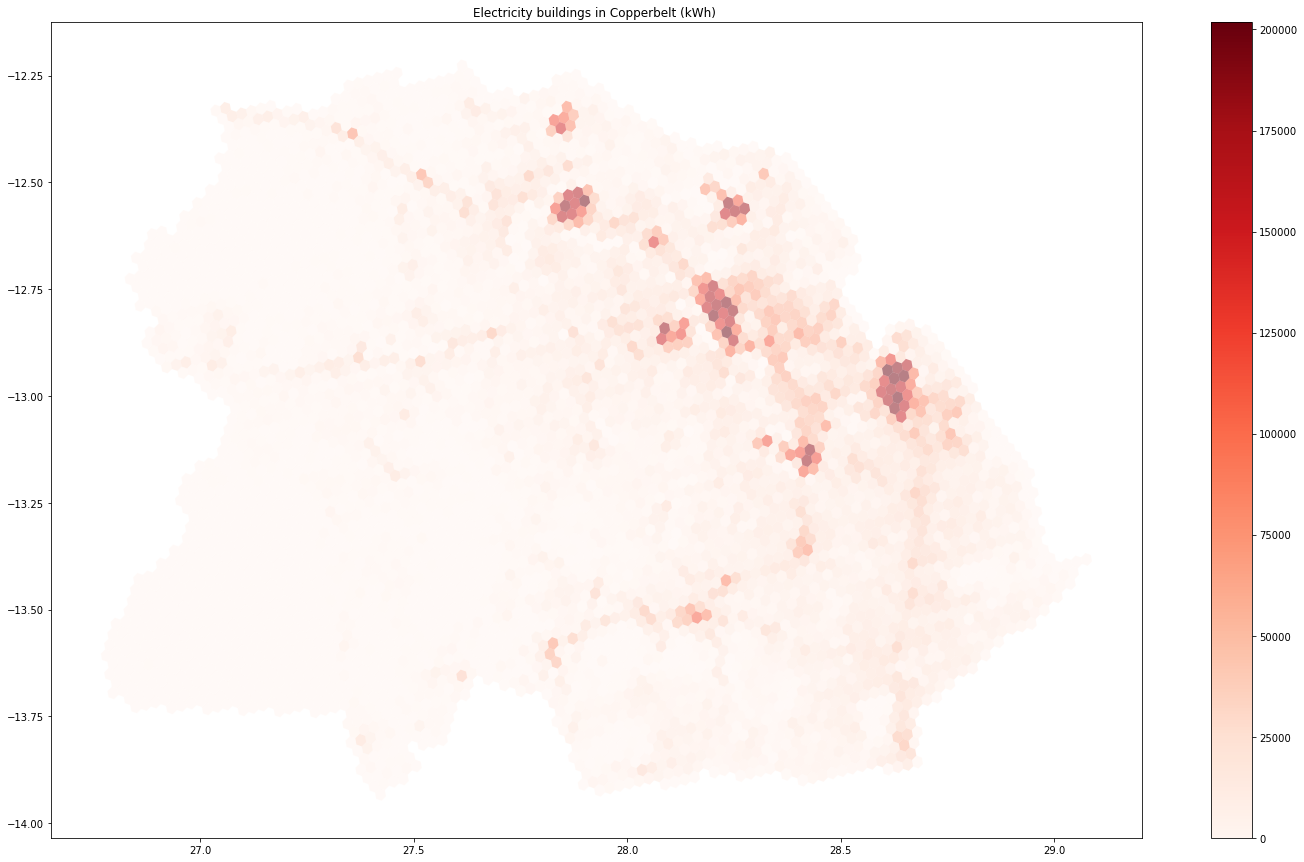

In [188]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot all crops
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity buildings in {} '.format("Copperbelt (kWh)") )

# Save plot as figure 
plt.savefig('sample_priority_map.png', bbox_inches='tight')